In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


200
torch.Size([3, 808, 828])
200
torch.Size([3, 808, 828])
200
torch.Size([3, 3232, 3312])
torch.Size([3, 808, 828])


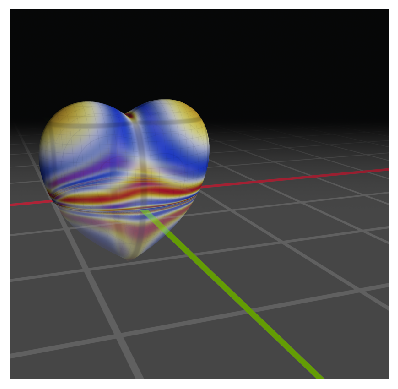

In [166]:
from PIL import Image
import requests
from io import BytesIO

def load_image(url):
    r =  requests.get(url)
    print(r.status_code)
    image = Image.open(BytesIO(r.content))
    transform = transforms.Compose([transforms.ToTensor()])
    torch_image = transform(image)[:3]
    print(torch_image.shape)
    return torch_image

imgs_noisy = [
    load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161030653052203080/0.png"),
    load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161030653400318052/1.png"),
    # load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161030653983342772/2.png"),
    # load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161030654897696808/3.png")
]
imgs_ref = load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161030698082242600/4.png")
imgs_ref = torch.mean(imgs_ref.reshape((3, imgs_ref.shape[1]//4, 4, imgs_ref.shape[2]//4, 4)), axis=(2, 4))
print(imgs_ref.shape)

# imgs_noisy = [
#     load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161039873927565383/0.png"),
#     load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161039874456039504/1.png"),
#     # load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161039874795773952/2.png"),
#     # load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161039875122942082/3.png")
# ]
# imgs_ref = load_image("https://cdn.discordapp.com/attachments/931320571453653072/1161040376237400114/4.png")
# print(imgs_ref.shape)


def plot_imgs(x):
    plt.figure()
    plt.imshow(x.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

plot_imgs(imgs_ref)


torch.Size([32, 3, 32, 32])


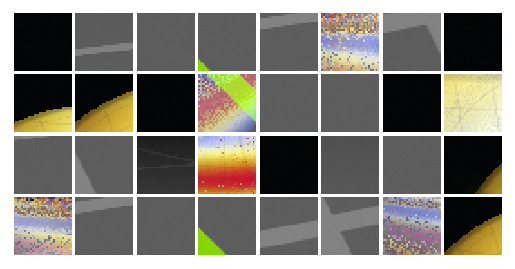

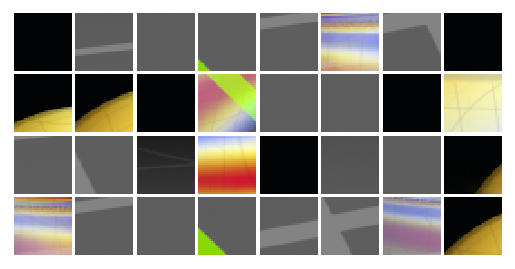

In [180]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        s = 32
        self.n = n
        self.s = s
        w, h = imgs_ref.shape[1:]
        self.coords = [
            torch.randint(0, len(imgs_noisy), (n,)),
            torch.randint(0, w-s, (n,)),
            torch.randint(0, h-s, (n,))
        ]

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k = self.coords[0][i]
        x = self.coords[1][i]
        y = self.coords[2][i]
        s = self.s
        return [
            imgs_noisy[k][:, x:x+s, y:y+s],
            imgs_ref[:, x:x+s, y:y+s]
        ]


def plot_imgs(x):
    plt.figure()
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=32,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [181]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=False)

def relu(x):
    return F.relu(x, inplace=True)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n = 8
        self.conv1 = conv3(3, n)
        self.conv2 = conv3(n, n)
        self.conv3 = conv3(n, n)
        self.conv4 = conv3(n, n)
        self.conv5 = conv3(n, 3)

    def forward(self, input):
        x = input
        c1 = self.conv1(x)
        x = relu(c1)
        c2 = self.conv2(x)
        x = relu(c2)
        c3 = self.conv3(x+c1)
        # c3 = self.conv3(x)
        x = relu(c3)
        c4 = self.conv4(x)
        x = relu(c4)
        c5 = self.conv5(x+c3)
        # c5 = self.conv5(x)
        return c5
        return c3+input

    # def forward(self, input):
    #     return torch.cat((
    #         self.forward1(input[:, 0:1]),
    #         self.forward1(input[:, 1:2]),
    #         self.forward1(input[:, 2:3])
    #     ), 1)

model = Model().to(device)
print(model)

Model(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


2000 0.01134811993688345


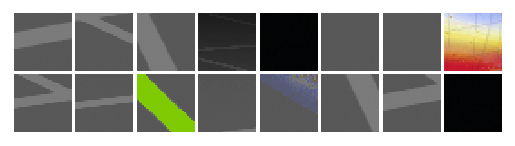

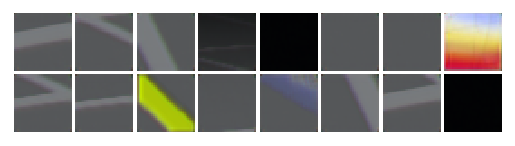

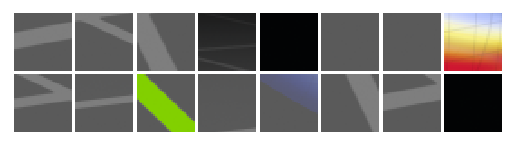

4000 0.009024329483509064


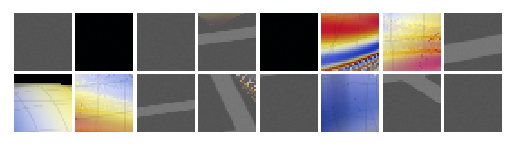

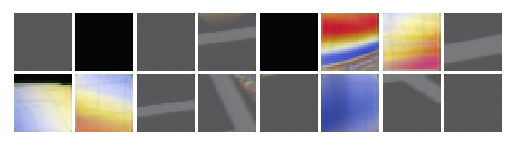

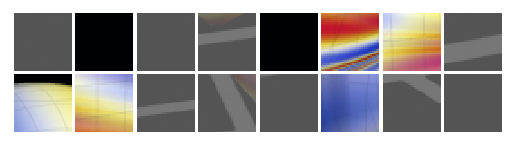

6000 0.007983658462762833


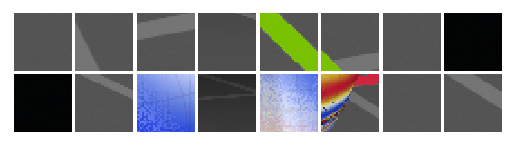

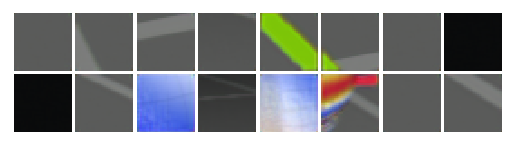

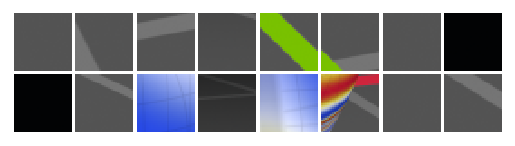

8000 0.0031396853737533092


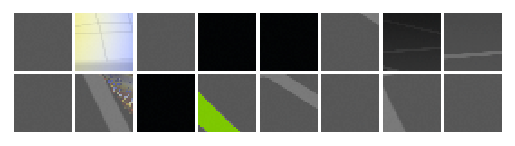

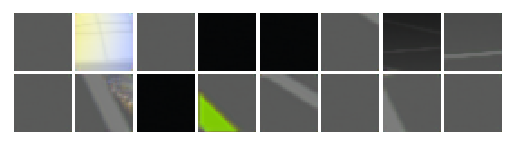

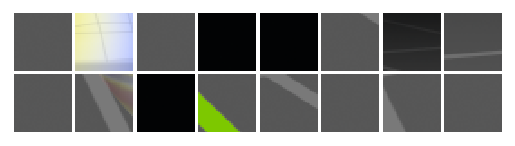

10000 0.006700371857732534


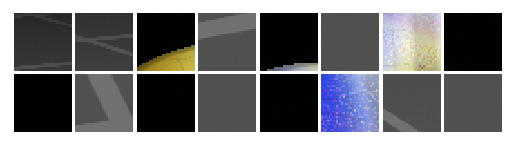

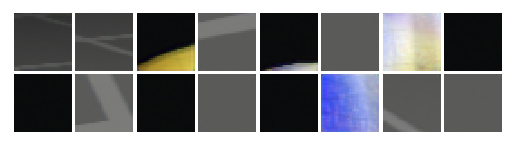

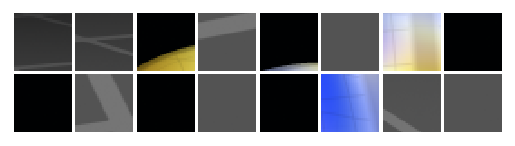

12000 0.0072189150378108025


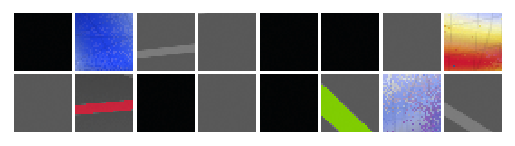

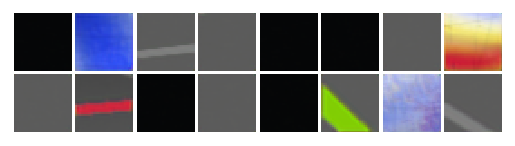

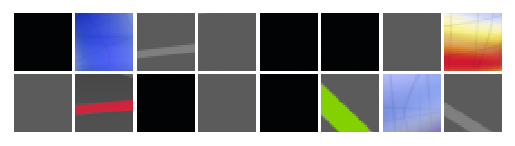

14000 0.007903535850346088


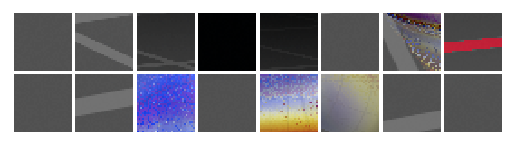

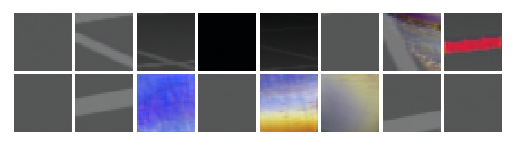

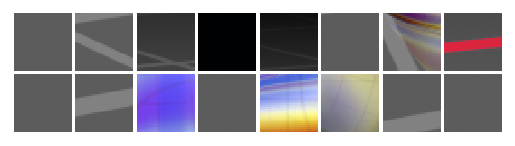

16000 0.010510320775210857


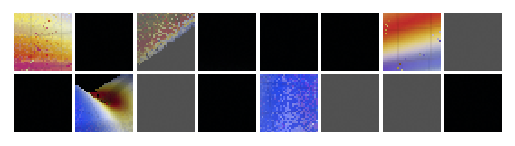

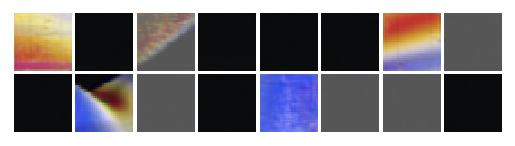

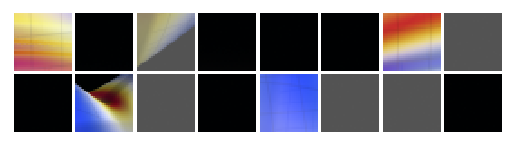

18000 0.002672095550224185


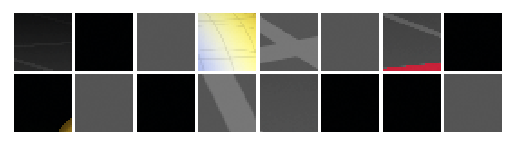

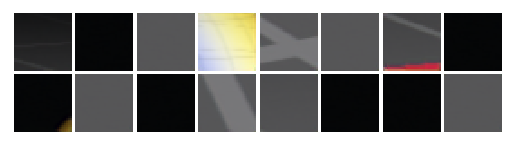

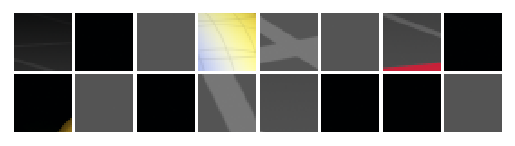

20000 0.0029082195833325386


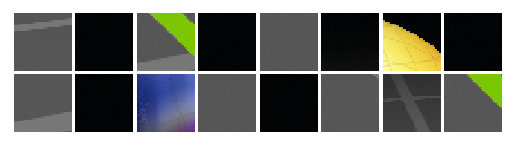

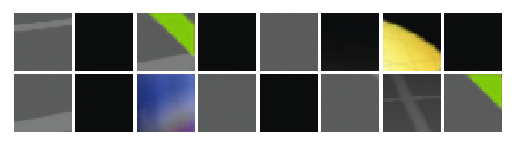

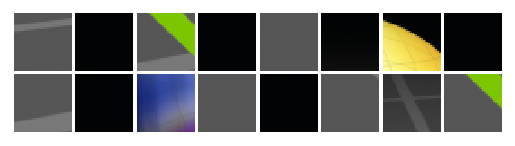

In [182]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005
)

from lpips_pytorch import LPIPS, lpips
criterion = LPIPS(
    net_type='squeeze',
    version='0.1'
).to(device)
for x, y in torch.utils.data.DataLoader(RawDataset(16), batch_size=16):
    loss = criterion(model(x.to(device)), y.to(device))

def lossfun(output, reference, input):
    return torch.mean(torch.abs(output-reference))
    penalty = 0.5+0.5*torch.sign((output-reference)*(reference-input))
    # return torch.mean(torch.abs(output-reference)*(1.0+1.0*penalty))
    loss = lpips(output, reference, net_type='squeeze', version='0.1')
    return loss * (1.0+9.0*torch.mean(penalty))

batch_count = 0
for epoch in range(5):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(65536), batch_size=16, shuffle=True)
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = lossfun(output, y, x)
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 2000 == 0:
            print(batch_count, loss.item())
            plot_imgs(x)
            plot_imgs(output.detach())
            plot_imgs(y)


In [183]:
torch.save(model, "seq_implicit3.pth")